# Imports and preparation

In [1]:
import os

In [2]:
import torch

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
from tqdm import tqdm

In [6]:
import time, gc

In [7]:
import importlib

In [8]:
from itertools import product


In [9]:
from util import util_elastic

OpenAI tiktoken module is not available for Python < 3.8,Linux ARM64 and AARCH64. Falling back to GPT2TokenizerFast.


In [10]:
from util import util_pipeline_v2 as util_pipeline

In [11]:
from util import util_experiment_juris_tcu as util_experiment

In [12]:
# Para ter repetibilidade nos resultados
random_state = 1

# Tratar valores infinitos (+ e -) como np.NaN
pd.options.mode.use_inf_as_na = True

# IMPORTANTE para tornar figuras interativas
# %matplotlib notebook

# Tamanho padrão das figuras
figsize=(10,6)

pd.set_option('display.max_row', 1000)

pd.set_option('display.max_columns', 50)

pd.set_option('display.column_space', 100)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.width', 200)


In [13]:
DATASET_NAME = 'juris_tcu'

In [14]:

PATH_QREL =  f'../data/{DATASET_NAME}/qrel.csv'

In [15]:
EXPANSOR_CRITERIA = 'join_bm25_sts_30_minilm_indir'

In [16]:
consider_query_expanded = True

if consider_query_expanded:
    PATH_QUERY =  f'../data/juris_tcu_expanded_query/query_10_expansion_{EXPANSOR_CRITERIA}.csv' 
else:
    PATH_QUERY = f'../data/{DATASET_NAME}/query.csv'

# Data load

## Query data load

In [17]:
df_query = pd.read_csv(PATH_QUERY)

In [18]:
df_query.shape

(150, 13)

In [19]:
df_query.head()

,ID,TEXT,SOURCE,1,2,3,4,5,6,7,8,9,10
0,1,técnica e preço,search log,técnica e preço - Licitação de técnica e preço,"técnica e preço - Licitação de técnica e preço, Proposta técnica","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica, Proposta de preço","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica, Proposta de preço, Preço máximo","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica, Proposta de preço, Preço máximo, Preço estimado","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica, Proposta de preço, Preço máximo, Preço estimado, Proposta","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica, Proposta de preço, Preço máximo, Preço estimado, Proposta"
1,2,restos a pagar,search log,restos a pagar - Recolhimento,"restos a pagar - Recolhimento, Recompensa","restos a pagar - Recolhimento, Recompensa, Dívida","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa, Empenho","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa, Empenho, Recibado","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa, Empenho, Recibado, Pagamento indevido","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa, Empenho, Recibado, Pagamento indevido, Seguro de vida","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa, Empenho, Recibado, Pagamento indevido, Seguro de vida"
2,3,aditivo a contrato,search log,aditivo a contrato - Termo aditivo,"aditivo a contrato - Termo aditivo, Acréscimo","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação, Reenquadramento","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação, Reenquadramento, Contrato administrativo","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação, Reenquadramento, Contrato administrativo, Contrato de escopo","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação, Reenquadramento, Contrato administrativo, Contrato de escopo","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação, Reenquadramento, Contrato administrativo, Contrato de escopo"
3,4,adesão a ata de registro de preços,search log,adesão a ata de registro de preços - Sistema de Registro de Preços,"adesão a ata de registro de preços - Sistema de Registro de Preços, Ato sujeito a registro","adesão a ata de registro de preços - Sistema de Registro de Preços, Ato sujeito a registro, Intenção de Registro de Preços","adesão a ata de registro de preços - Sistema de Registro de Preços, Ato sujeito a registro, Intenção de Registro de Preços, Autoridade de registro","adesão a ata de registro de preços - Sistema de Registro de Preços, Ato sujeito a registro, Intenção de Registro de Preços, Autoridade de registro, Planilha de custos e formação de preços","adesão a ata de registro de preços - Sistema de Reg

In [20]:
df_query = df_query.reset_index(drop=True)

## Qrel data load

In [21]:
df_qrel = pd.read_csv(PATH_QREL)

In [22]:
df_qrel.shape

(2250, 5)

In [23]:
df_qrel.head(15)

,QUERY_ID,DOC_ID,SCORE,ENGINE,RANK
0,1,21064,3,(BM25|STS)+Reranker+LLM,1
1,1,42166,3,(BM25|STS)+Reranker+LLM,2
2,1,13702,3,(BM25|STS)+Reranker+LLM,3
3,1,20592,3,(BM25|STS)+Reranker+LLM,4
4,1,15740,3,(BM25|STS)+Reranker+LLM,5
5,1,53641,3,(BM25|STS)+Reranker+LLM,6
6,1,31601,3,(BM25|STS)+Reranker+LLM,7
7,1,54765,3,(BM25|STS)+Reranker+LLM,8
8,1,20506,3,(BM25|STS)+Reranker+LLM,9
9,1,47161,3,(BM25|STS)+Reranker+LLM,10


In [24]:
df_qrel.shape[0]

2250

In [25]:
df_search_data = df_query.merge(df_qrel, how='left', left_on='ID', right_on='QUERY_ID').drop('QUERY_ID', axis=1)

In [26]:
df_search_data.shape


(2250, 17)

In [27]:
# Agrupar os dados pelo ID e criar a coluna 'RELEVANCE_LIST' com a lista de tuplas
# df_new = df_search_data.groupby('ID').apply(lambda x: list(zip(x['DOC_ID'], x['TYPE']))).reset_index(name='RELEVANCE_LIST')
# df_new['RELEVANCE_LIST'] = df_new['RELEVANCE_LIST'].apply(lambda x: sorted(x, key=lambda tup: ('AREA', 'TEMA', 'SUBTEMA', 'INDEXACAO_EXTRA').index(tup[1])))
df_new = df_search_data.groupby('ID').apply(lambda x: dict(zip(x['DOC_ID'], x['SCORE']))).reset_index(name='RELEVANCE_DICT')


In [28]:
df_new.head()

,ID,RELEVANCE_DICT
0,1,"{21064: 3, 42166: 3, 13702: 3, 20592: 3, 15740: 3, 53641: 3, 31601: 3, 54765: 3, 20506: 3, 47161: 3, 161: 1, 11595: 1, 40647: 1, 22155: 1, 18435: 1}"
1,2,"{31437: 3, 19340: 3, 77959: 3, 17289: 2, 18452: 2, 18105: 1, 19636: 1, 31274: 0, 17258: 0, 32865: 0, 19738: 0, 104484: 0, 90647: 0, 21876: 0, 33096: 0}"
2,3,"{18380: 3, 31102: 3, 17240: 3, 20511: 3, 32589: 3, 20510: 3, 17816: 3, 18058: 2, 17225: 2, 57354: 2, 18003: 2, 3881: 2, 31096: 1, 20901: 1, 11621: 1}"
3,4,"{16895: 3, 45015: 3, 14526: 3, 62306: 3, 6237: 3, 50537: 3, 16981: 3, 21201: 3, 77927: 3, 84935: 3, 22098: 1, 18410: 1, 8858: 1, 60811: 0, 42906: 0}"
4,5,"{21172: 3, 17816: 3, 4066: 3, 53003: 3, 94290: 3, 114656: 3, 50616: 3, 144170: 3, 16277: 3, 59226: 3, 18047: 2, 31612: 1, 18036: 1, 42583: 0, 29387: 0}"


In [29]:
# Unir o resultado com as demais colunas únicas
df_new = pd.merge(df_new, df_search_data.drop_duplicates('ID'), on='ID', how='left')

In [30]:
df_new.columns

Index(['ID', 'RELEVANCE_DICT', 'TEXT', 'SOURCE', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'DOC_ID', 'SCORE', 'ENGINE', 'RANK'], dtype='object')

In [31]:
df_search_data = df_new.drop(['DOC_ID', 'SCORE', 'ENGINE', 'RANK'], axis=1)

In [32]:
df_search_data.shape

(150, 14)

In [33]:
df_search_data.head()

,ID,RELEVANCE_DICT,TEXT,SOURCE,1,2,3,4,5,6,7,8,9,10
0,1,"{21064: 3, 42166: 3, 13702: 3, 20592: 3, 15740: 3, 53641: 3, 31601: 3, 54765: 3, 20506: 3, 47161: 3, 161: 1, 11595: 1, 40647: 1, 22155: 1, 18435: 1}",técnica e preço,search log,técnica e preço - Licitação de técnica e preço,"técnica e preço - Licitação de técnica e preço, Proposta técnica","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica, Proposta de preço","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica, Proposta de preço, Preço máximo","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica, Proposta de preço, Preço máximo, Preço estimado","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica, Proposta de preço, Preço máximo, Preço estimado, Proposta","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica, Proposta de preço, Preço máximo, Preço estimado, Proposta"
1,2,"{31437: 3, 19340: 3, 77959: 3, 17289: 2, 18452: 2, 18105: 1, 19636: 1, 31274: 0, 17258: 0, 32865: 0, 19738: 0, 104484: 0, 90647: 0, 21876: 0, 33096: 0}",restos a pagar,search log,restos a pagar - Recolhimento,"restos a pagar - Recolhimento, Recompensa","restos a pagar - Recolhimento, Recompensa, Dívida","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa, Empenho","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa, Empenho, Recibado","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa, Empenho, Recibado, Pagamento indevido","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa, Empenho, Recibado, Pagamento indevido, Seguro de vida","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa, Empenho, Recibado, Pagamento indevido, Seguro de vida"
2,3,"{18380: 3, 31102: 3, 17240: 3, 20511: 3, 32589: 3, 20510: 3, 17816: 3, 18058: 2, 17225: 2, 57354: 2, 18003: 2, 3881: 2, 31096: 1, 20901: 1, 11621: 1}",aditivo a contrato,search log,aditivo a contrato - Termo aditivo,"aditivo a contrato - Termo aditivo, Acréscimo","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação, Reenquadramento","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação, Reenquadramento, Contrato administrativo","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação, Reenquadramento, Contrato administrativo, Contrato de escopo","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação, Reenquadramento, Contrato administrativo, Contrato de escopo","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação, Reenquadramento, Contrato administrativo, Contrato de escopo"
3,4,"{16895: 3, 45015: 3, 14526: 3, 62306: 3, 6237: 3, 50537: 3, 16981: 3, 21201: 3, 77927: 3, 84935: 3, 22098: 1, 18410: 1, 8858: 1, 60811: 0, 42906: 0}",adesão a ata de registro de preços,search log,adesão a ata de registro de preços - Sistema de Regis

In [34]:
del df_new

# Create reference to index (elastic search)

Documentation https://docs.haystack.deepset.ai/docs
https://haystack.deepset.ai/tutorials/09_dpr_training 


In [35]:
index_dict = util_elastic.return_indexes('indir', parm_print=True)

Index: indir_juris_tcu
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu', 'uuid': 'RD_aAWppQH6vjNxKUdL_0w', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'docs.deleted': '16045', 'store.size': '334.9mb', 'pri.store.size': '334.9mb'}

Index: indir_juris_tcu_term
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu_term', 'uuid': 'S5WlNGiqSXC-79WaqfsddA', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'docs.deleted': '16045', 'store.size': '337.5mb', 'pri.store.size': '337.5mb'}

Index: indir_juris_tcu_synonym_related_term
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu_synonym_related_term', 'uuid': 'OJIJ0P2XQo-s4NRuaT4W_w', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'docs.deleted': '3045', 'store.size': '348.4mb', 'pri.store.size': '348.4mb'}

Index: indir_juris_tcu_related_term
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu_related_term', 'uuid': 'i9nzlBQrREyEC7MGT79GBQ', 'pri': '1', 'rep': '1', 'docs.count': '16045',

In [36]:
index_dict

{'indir_juris_tcu': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu',
  'uuid': 'RD_aAWppQH6vjNxKUdL_0w',
  'pri': '1',
  'rep': '1',
  'docs.count': '16045',
  'docs.deleted': '16045',
  'store.size': '334.9mb',
  'pri.store.size': '334.9mb'},
 'indir_juris_tcu_term': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu_term',
  'uuid': 'S5WlNGiqSXC-79WaqfsddA',
  'pri': '1',
  'rep': '1',
  'docs.count': '16045',
  'docs.deleted': '16045',
  'store.size': '337.5mb',
  'pri.store.size': '337.5mb'},
 'indir_juris_tcu_synonym_related_term': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu_synonym_related_term',
  'uuid': 'OJIJ0P2XQo-s4NRuaT4W_w',
  'pri': '1',
  'rep': '1',
  'docs.count': '16045',
  'docs.deleted': '3045',
  'store.size': '348.4mb',
  'pri.store.size': '348.4mb'},
 'indir_juris_tcu_related_term': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu_related_term',
  'uuid': 'i9nzlBQrREyEC7MGT79GBQ'

In [37]:
list_name_index = ['indir_juris_tcu', 'indir_juris_tcu_term', 'indir_juris_tcu_synonym', 'indir_juris_tcu_related_term', 'indir_juris_tcu_synonym_related_term' ]

In [38]:
reference_data_index = {}

In [39]:
%%time
for index_name in list_name_index:
    reference_data_index[index_name] = util_elastic.return_index(parm_index_name=index_name, parm_embedding_dim=1024)


Qtd de documentos 16045

Qtd de embeddings 16045

Documento.id=5: <Document: id=5, content='SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial com fu...'>

Qtd de documentos 16045

Qtd de embeddings 16045

Documento.id=5: <Document: id=5, content='SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial com fu...'>

Qtd de documentos 16045

Qtd de embeddings 16045

Documento.id=5: <Document: id=5, content='SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial com fu...'>

Qtd de documentos 16045

Qtd de embeddings 16045

Documento.id=5: <Document: id=5, content='SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial com fu...'>

Qtd de documentos 16045

Qtd de embeddings 16045

Documento.id=5: <Document: id=5, content='SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial com fu...'>
CPU t

# Pipelines creation

In [40]:
# Test query
# parm_query = "trata-se de uma denúncia contra o prefeito de Manhuaçu por não haver pago os funcionários da área de limpeza urbana"
parm_query = "despesa sem cobertura contratual"

In [41]:
pipes = {}
for index_name in list_name_index:
    pipes[index_name] = []


In [44]:
ranker_type = 'MINILM_INDIR_400' # 'MT5_3B' # 'MT5_TRAINED_LIM50_800' # 'MINILM_TRAINED_19000'

In [47]:
limit_query_size_expanded = 100

In [43]:
raise Exception("Stop here")

Exception: Stop here

In [45]:
ranker_type

'MINILM_INDIR_400'

## Only retrievers

### bm25

In [ ]:
%%time
for index_name in list_name_index:
    pipe = {}
    pipe['PIPE_OBJECT'] = util_pipeline.return_pipeline_bm25(reference_data_index[index_name])
    pipe['RETRIEVER_TYPE'] = 'bm25'
    pipe['RANKER_TYPE'] = 'none'
    pipe['RETRIEVER_MODEL_NAME'] = ''
    pipes[index_name].append(pipe)


CPU times: user 956 µs, sys: 0 ns, total: 956 µs
Wall time: 956 µs


In [ ]:
%%time
for index_name in pipes:
    print(f"\nindex_name {index_name}")
    for pipe in pipes[index_name]:
        print(f"*** retriever:{pipe['RETRIEVER_TYPE']} / ranker:{pipe['RANKER_TYPE']}")
        doctos_retornados_ranker =  pipe['PIPE_OBJECT'].run(query=parm_query, 
        params={"Retriever": {"top_k": 100}})
        print(f'\nIndex: {index_name}')
        util_pipeline.detail_document_found(doctos_retornados_ranker,5)


index_name indir_juris_tcu
*** retriever:bm25 / ranker:none

Index: indir_juris_tcu
Parâmetros usados: {'Retriever': {'top_k': 100}}
Consulta: despesa sem cobertura contratual
Qtd documentos retornados: 100
Seguem os nomes dos termos recuperados em ordem de score
0 : [0.9497785738073338, '18384', 'A realização de pagamentos em data anterior à celebração do contrato caracteriza despesa sem cobertura contratual.']
1 : [0.9172683438466377, '17993', 'O pagamento pela realização de serviços novos, não contidos no projeto originalmente licitado, utilizando-se para faturamento serviços constantes na planilha de preços original, sem a respectiva execução, é despesa sem cobertura contratual, a justificar aplicação de multa aos responsáveis envolvidos.']
2 : [0.8962556736040861, '18905', 'A execução de serviços sem cobertura contratual, mas autorizados pela Administração, gera o dever de indenizar.']
3 : [0.889172123906067, '18950', 'A realização de pagamentos previamente à assinatura dos respe

## With rankers

In [ ]:
importlib.reload(util_pipeline)

<module 'util.util_pipeline_v2' from '/home/borela/fontes/ind-ir/code/util/util_pipeline_v2.py'>

### First stage = BM25

In [ ]:
%%time
for index_name in list_name_index:
    pipe = {}
    pipe['PIPE_OBJECT'] = util_pipeline.return_pipeline_bm25_reranker(reference_data_index[index_name], ranker_type, 
                                parm_limit_query_size=limit_query_size_expanded)
    pipe['RETRIEVER_TYPE'] = 'bm25'
    pipe['RANKER_TYPE'] = ranker_type
    pipe['RETRIEVER_MODEL_NAME'] = ''
    pipes[index_name].append(pipe)


Loading MINILM_INDIR with limit_query_size=100
CPU times: user 4.02 s, sys: 1.35 s, total: 5.37 s
Wall time: 4.87 s


In [ ]:

%%time
for index_name in pipes:
    print(f"\nindex_name {index_name}")
    for pipe in pipes[index_name]:
        print(f"*** retriever:{pipe['RETRIEVER_TYPE']} / ranker:{pipe['RANKER_TYPE']}")
        doctos_retornados_ranker =  pipe['PIPE_OBJECT'].run(query=parm_query, 
        params={"Retriever": {"top_k": 100}})
        print(f'\nIndex: {index_name}')
        util_pipeline.detail_document_found(doctos_retornados_ranker,5)
        torch.cuda.empty_cache()


index_name indir_juris_tcu
*** retriever:bm25 / ranker:none

Index: indir_juris_tcu
Parâmetros usados: {'Retriever': {'top_k': 100}}
Consulta: despesa sem cobertura contratual
Qtd documentos retornados: 100
Seguem os nomes dos termos recuperados em ordem de score
0 : [0.9497785738073338, '18384', 'A realização de pagamentos em data anterior à celebração do contrato caracteriza despesa sem cobertura contratual.']
1 : [0.9172683438466377, '17993', 'O pagamento pela realização de serviços novos, não contidos no projeto originalmente licitado, utilizando-se para faturamento serviços constantes na planilha de preços original, sem a respectiva execução, é despesa sem cobertura contratual, a justificar aplicação de multa aos responsáveis envolvidos.']
2 : [0.8962556736040861, '18905', 'A execução de serviços sem cobertura contratual, mas autorizados pela Administração, gera o dever de indenizar.']
3 : [0.889172123906067, '18950', 'A realização de pagamentos previamente à assinatura dos respe

### First stage = Sentence Similarity

In [ ]:
%%time
for index_name in list_name_index:
    pipe = {}
    pipe['PIPE_OBJECT'] = util_pipeline.return_pipeline_sts_reranker(reference_data_index[index_name], ranker_type, 
                                parm_limit_query_size=limit_query_size_expanded)
    pipe['RETRIEVER_TYPE'] = 'sts'
    pipe['RANKER_TYPE'] = ranker_type
    pipe['RETRIEVER_MODEL_NAME'] = ''
    pipes[index_name].append(pipe)


CPU times: user 14.6 s, sys: 1.97 s, total: 16.6 s
Wall time: 9.08 s


In [ ]:

%%time
for index_name in pipes:
    print(f"\nindex_name {index_name}")
    for pipe in pipes[index_name]:
        print(f"*** retriever:{pipe['RETRIEVER_TYPE']} / ranker:{pipe['RANKER_TYPE']}")
        doctos_retornados_ranker =  pipe['PIPE_OBJECT'].run(query=parm_query, 
        params={"Retriever": {"top_k": 100}})
        print(f'\nIndex: {index_name}')
        util_pipeline.detail_document_found(doctos_retornados_ranker,5)
        torch.cuda.empty_cache()


index_name indir_juris_tcu
*** retriever:bm25 / ranker:none

Index: indir_juris_tcu
Parâmetros usados: {'Retriever': {'top_k': 100}}
Consulta: despesa sem cobertura contratual
Qtd documentos retornados: 100
Seguem os nomes dos termos recuperados em ordem de score
0 : [0.9497785738073338, '18384', 'A realização de pagamentos em data anterior à celebração do contrato caracteriza despesa sem cobertura contratual.']
1 : [0.9172683438466377, '17993', 'O pagamento pela realização de serviços novos, não contidos no projeto originalmente licitado, utilizando-se para faturamento serviços constantes na planilha de preços original, sem a respectiva execução, é despesa sem cobertura contratual, a justificar aplicação de multa aos responsáveis envolvidos.']
2 : [0.8962556736040861, '18905', 'A execução de serviços sem cobertura contratual, mas autorizados pela Administração, gera o dever de indenizar.']
3 : [0.889172123906067, '18950', 'A realização de pagamentos previamente à assinatura dos respe

### First stage = join

In [48]:
%%time
for index_name in list_name_index:
    pipe = {}
    pipe['PIPE_OBJECT'] = util_pipeline.return_pipeline_join_bm25_sts_reranker(reference_data_index[index_name], ranker_type, 
                                parm_limit_query_size=limit_query_size_expanded)
    pipe['RETRIEVER_TYPE'] = 'join'
    pipe['RANKER_TYPE'] = ranker_type
    pipe['RETRIEVER_MODEL_NAME'] = ''
    pipes[index_name].append(pipe)


Loading MINILM_INDIR_400 with limit_query_size=100
CPU times: user 19 s, sys: 3.61 s, total: 22.6 s
Wall time: 14.2 s


In [50]:

%%time
for index_name in pipes:
    print(f"\nindex_name {index_name}")
    for pipe in pipes[index_name]:
        print(f"*** retriever:{pipe['RETRIEVER_TYPE']} / ranker:{pipe['RANKER_TYPE']}")
        doctos_retornados_ranker =  pipe['PIPE_OBJECT'].run(query=parm_query, 
        params={
        "Bm25Retriever":{"top_k": 100},
        "StsRetriever": {"top_k": 100}
        })
        print(f'\nIndex: {index_name}')
        util_pipeline.detail_document_found(doctos_retornados_ranker,5)
        torch.cuda.empty_cache()


index_name indir_juris_tcu
*** retriever:join / ranker:MINILM_INDIR_400

Index: indir_juris_tcu
Parâmetros usados: {'Bm25Retriever': {'top_k': 100}, 'StsRetriever': {'top_k': 100}}
Consulta: despesa sem cobertura contratual
Qtd documentos retornados: 188
Seguem os nomes dos termos recuperados em ordem de score
0 : [0.7853959798812866, '19451', 'A realização de despesas sem cobertura contratual é irregularidade grave, que justifica a aplicação de multa aos responsáveis, bem como julgamento pela irregularidade de suas contas']
1 : [0.7202020883560181, '17825', 'Pagamentos sem cobertura contratual ou prévio empenho constituem afronta à legislação ordinária, ressalvando-se, no que diz respeito à Lei 8.666/1993, os contratos verbais destinados às compras de pronto pagamento, feitas em regime de adiantamento, em valores não superiores ao estabelecido na norma (parágrafo único do art. 60) .']
2 : [0.6971409916877747, '18384', 'A realização de pagamentos em data anterior à celebração do contr

## Impressão de pipe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


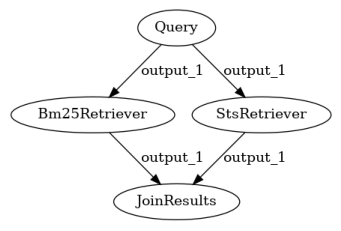

In [ ]:
util_pipeline.imprime_pipe(pipe_join_sts_multihop_bm25)

# Experiments

In [51]:
pipes

{'indir_juris_tcu': [{'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7f1dbb3bfe10>,
   'RETRIEVER_TYPE': 'join',
   'RANKER_TYPE': 'MINILM_INDIR_400',
   'RETRIEVER_MODEL_NAME': ''}],
 'indir_juris_tcu_term': [{'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7f1dc4624910>,
   'RETRIEVER_TYPE': 'join',
   'RANKER_TYPE': 'MINILM_INDIR_400',
   'RETRIEVER_MODEL_NAME': ''}],
 'indir_juris_tcu_synonym': [{'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7f1db0360fd0>,
   'RETRIEVER_TYPE': 'join',
   'RANKER_TYPE': 'MINILM_INDIR_400',
   'RETRIEVER_MODEL_NAME': ''}],
 'indir_juris_tcu_related_term': [{'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7f1db816b9d0>,
   'RETRIEVER_TYPE': 'join',
   'RANKER_TYPE': 'MINILM_INDIR_400',
   'RETRIEVER_MODEL_NAME': ''}],
 'indir_juris_tcu_synonym_related_term': [{'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7f1dbb186d50>,
   'RETRIEVER_TYPE': 'join',
   'RANKER_TYPE': 'MINILM_INDIR_400',
   'RETRIEVER_MODEL_NAME': ''}]

In [52]:
grid_experiment = { 
             'TOPK_RETRIEVER' : [300],
             'TOPK_RANKER' : [0],
}

In [53]:
list_experiment = [dict(zip(grid_experiment.keys(), values)) for values in product(*grid_experiment.values())]


In [54]:
print(len(list_experiment))
gc.collect()

1


84

In [55]:
pipes['indir_juris_tcu'][0].keys()

dict_keys(['PIPE_OBJECT', 'RETRIEVER_TYPE', 'RANKER_TYPE', 'RETRIEVER_MODEL_NAME'])

In [56]:
df_search_data.head()

,ID,RELEVANCE_DICT,TEXT,SOURCE,1,2,3,4,5,6,7,8,9,10
0,1,"{21064: 3, 42166: 3, 13702: 3, 20592: 3, 15740: 3, 53641: 3, 31601: 3, 54765: 3, 20506: 3, 47161: 3, 161: 1, 11595: 1, 40647: 1, 22155: 1, 18435: 1}",técnica e preço,search log,técnica e preço - Licitação de técnica e preço,"técnica e preço - Licitação de técnica e preço, Proposta técnica","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica, Proposta de preço","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica, Proposta de preço, Preço máximo","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica, Proposta de preço, Preço máximo, Preço estimado","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica, Proposta de preço, Preço máximo, Preço estimado, Proposta","técnica e preço - Licitação de técnica e preço, Proposta técnica, Preço médio, Preço de mercado, Técnica jurídica, Proposta de preço, Preço máximo, Preço estimado, Proposta"
1,2,"{31437: 3, 19340: 3, 77959: 3, 17289: 2, 18452: 2, 18105: 1, 19636: 1, 31274: 0, 17258: 0, 32865: 0, 19738: 0, 104484: 0, 90647: 0, 21876: 0, 33096: 0}",restos a pagar,search log,restos a pagar - Recolhimento,"restos a pagar - Recolhimento, Recompensa","restos a pagar - Recolhimento, Recompensa, Dívida","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa, Empenho","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa, Empenho, Recibado","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa, Empenho, Recibado, Pagamento indevido","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa, Empenho, Recibado, Pagamento indevido, Seguro de vida","restos a pagar - Recolhimento, Recompensa, Dívida, Obrigação, Nota de empenho de despesa, Empenho, Recibado, Pagamento indevido, Seguro de vida"
2,3,"{18380: 3, 31102: 3, 17240: 3, 20511: 3, 32589: 3, 20510: 3, 17816: 3, 18058: 2, 17225: 2, 57354: 2, 18003: 2, 3881: 2, 31096: 1, 20901: 1, 11621: 1}",aditivo a contrato,search log,aditivo a contrato - Termo aditivo,"aditivo a contrato - Termo aditivo, Acréscimo","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação, Reenquadramento","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação, Reenquadramento, Contrato administrativo","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação, Reenquadramento, Contrato administrativo, Contrato de escopo","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação, Reenquadramento, Contrato administrativo, Contrato de escopo","aditivo a contrato - Termo aditivo, Acréscimo, Reprovabilidade, Atualização, Reformulação, Reenquadramento, Contrato administrativo, Contrato de escopo"
3,4,"{16895: 3, 45015: 3, 14526: 3, 62306: 3, 6237: 3, 50537: 3, 16981: 3, 21201: 3, 77927: 3, 84935: 3, 22098: 1, 18410: 1, 8858: 1, 60811: 0, 42906: 0}",adesão a ata de registro de preços,search log,adesão a ata de registro de preços - Sistema de Regis

In [ ]:
raise Exception ('Stop execution - create only desired pipelines in code below ')

Exception: Stop execution - create only desired pipelines in code below 

In [ ]:
importlib.reload(util_experiment)

<module 'util.util_experiment_juris_tcu' from '/home/borela/fontes/ind-ir/code/util/util_experiment_juris_tcu.py'>

In [57]:
consider_run_all = True

In [59]:
%%time
# colocar pequeno só para testes, depois voltar para 9999999 (número maior do que o número de termos a pesquisar)
limit_query =  9999999 # 100 # 
cnt_exec = 0
for index_name in pipes.keys():
    for pipe in pipes[index_name]:
        for cnt, experiment in enumerate(list_experiment):
            #  consider_query_expanded or only text column in case
            if consider_run_all:
                target_columns = df_search_data.columns.difference(['ID', 'RELEVANCE_DICT', 'SOURCE'])
            elif consider_query_expanded:
                target_columns = df_search_data.columns.difference(['ID', 'RELEVANCE_DICT', 'SOURCE', 'TEXT'])
            else:
                target_columns = ['TEXT']
            # print(target_columns)
            # raise Exception('false break')            
            for column_name in target_columns:
                cnt_exec += 1
                if column_name == 'TEXT':
                    experiment['EXPANSOR_CRITERIA'] = ""
                else:
                    experiment['EXPANSOR_CRITERIA'] = EXPANSOR_CRITERIA
                experiment['INDEX_NAME'] = index_name
                experiment['PIPE'] = pipe
                experiment['COLUMN_NAME'] = column_name
                print(f"=={cnt_exec}==  {time.strftime('%Y-%b-%d %H:%M:%S')} \nExperiment: {experiment}")
                list_result_experiment = [] # por experiment
                result_run = util_experiment.experiment_run(parm_df=df_search_data, 
                                                        parm_experiment=experiment,
                                                        parm_limit_query=limit_query,
                                                        parm_print=True)
                # raise Exception('false break')
                list_result_experiment.append(result_run)
                # print(f"qtd_encontrado sim:{result_run['qtd_encontrado']}, não:{result_run['qtd_nao_encontrado']} ({result_run['percent_nao_encontrado']}%)")
                util_experiment.add_experiment_result(parm_list_result=list_result_experiment, parm_dataset='juris_tcu')
                torch.cuda.empty_cache()


==1==  2023-Jun-28 08:06:53 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb3bfe10>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:06<00:00,  2.27it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.54
NDCG@5_MEAN: 46.697
NDCG@10_MEAN: 43.747
NDCG@15_MEAN: 46.538
NDCG@20_MEAN: 48.743
PRECISION@50_MEAN: 12.24
PRECISION@100_MEAN: 7.013
RECALL@50_MEAN: 40.8
RECALL@100_MEAN: 46.756
TIME_SPENT_MEAN: 0.441
==2==  2023-Jun-28 08:08:01 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb3bfe10>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:17<00:00,  1.93it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 3.711
NDCG@5_MEAN: 51.804
NDCG@10_MEAN: 48.376
NDCG@15_MEAN: 50.98
NDCG@20_MEAN: 53.627
PRECISION@50_MEAN: 12.44
PRECISION@100_MEAN: 6.907
RECALL@50_MEAN: 41.467
RECALL@100_MEAN: 46.044
TIME_SPENT_MEAN: 0.517
==3==  2023-Jun-28 08:09:20 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb3bfe10>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:08<00:00,  2.19it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.433
NDCG@5_MEAN: 47.636
NDCG@10_MEAN: 44.962
NDCG@15_MEAN: 47.054
NDCG@20_MEAN: 49.88
PRECISION@50_MEAN: 12.493
PRECISION@100_MEAN: 7.027
RECALL@50_MEAN: 41.644
RECALL@100_MEAN: 46.844
TIME_SPENT_MEAN: 0.456
==4==  2023-Jun-28 08:10:30 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb3bfe10>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:10<00:00,  2.13it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.653
NDCG@5_MEAN: 47.019
NDCG@10_MEAN: 44.435
NDCG@15_MEAN: 46.521
NDCG@20_MEAN: 49.096
PRECISION@50_MEAN: 12.107
PRECISION@100_MEAN: 6.873
RECALL@50_MEAN: 40.356
RECALL@100_MEAN: 45.822
TIME_SPENT_MEAN: 0.469
==5==  2023-Jun-28 08:11:42 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb3bfe10>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:11<00:00,  2.09it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.52
NDCG@5_MEAN: 48.154
NDCG@10_MEAN: 45.427
NDCG@15_MEAN: 47.753
NDCG@20_MEAN: 50.203
PRECISION@50_MEAN: 12.213
PRECISION@100_MEAN: 6.973
RECALL@50_MEAN: 40.711
RECALL@100_MEAN: 46.489
TIME_SPENT_MEAN: 0.479
==6==  2023-Jun-28 08:12:56 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb3bfe10>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:13<00:00,  2.05it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.173
NDCG@5_MEAN: 50.238
NDCG@10_MEAN: 46.724
NDCG@15_MEAN: 49.406
NDCG@20_MEAN: 51.766
PRECISION@50_MEAN: 12.44
PRECISION@100_MEAN: 7.053
RECALL@50_MEAN: 41.467
RECALL@100_MEAN: 47.022
TIME_SPENT_MEAN: 0.489
==7==  2023-Jun-28 08:14:11 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb3bfe10>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:15<00:00,  1.99it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.713
NDCG@5_MEAN: 49.285
NDCG@10_MEAN: 46.826
NDCG@15_MEAN: 49.207
NDCG@20_MEAN: 52.164
PRECISION@50_MEAN: 12.707
PRECISION@100_MEAN: 7.107
RECALL@50_MEAN: 42.356
RECALL@100_MEAN: 47.378
TIME_SPENT_MEAN: 0.504
==8==  2023-Jun-28 08:15:29 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb3bfe10>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:15<00:00,  2.00it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.967
NDCG@5_MEAN: 50.664
NDCG@10_MEAN: 47.373
NDCG@15_MEAN: 50.327
NDCG@20_MEAN: 53.147
PRECISION@50_MEAN: 12.573
PRECISION@100_MEAN: 7.087
RECALL@50_MEAN: 41.911
RECALL@100_MEAN: 47.244
TIME_SPENT_MEAN: 0.5
==9==  2023-Jun-28 08:16:45 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb3bfe10>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:15<00:00,  1.97it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 4.094
NDCG@5_MEAN: 51.691
NDCG@10_MEAN: 48.345
NDCG@15_MEAN: 51.05
NDCG@20_MEAN: 53.579
PRECISION@50_MEAN: 12.493
PRECISION@100_MEAN: 6.96
RECALL@50_MEAN: 41.644
RECALL@100_MEAN: 46.4
TIME_SPENT_MEAN: 0.506
==10==  2023-Jun-28 08:18:03 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb3bfe10>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:16<00:00,  1.96it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 3.987
NDCG@5_MEAN: 51.638
NDCG@10_MEAN: 48.357
NDCG@15_MEAN: 50.86
NDCG@20_MEAN: 53.588
PRECISION@50_MEAN: 12.48
PRECISION@100_MEAN: 6.933
RECALL@50_MEAN: 41.6
RECALL@100_MEAN: 46.222
TIME_SPENT_MEAN: 0.511
==11==  2023-Jun-28 08:19:22 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb3bfe10>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:04<00:00,  2.32it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.587
NDCG@5_MEAN: 46.359
NDCG@10_MEAN: 44.504
NDCG@15_MEAN: 47.482
NDCG@20_MEAN: 50.301
PRECISION@50_MEAN: 12.787
PRECISION@100_MEAN: 7.373
RECALL@50_MEAN: 42.622
RECALL@100_MEAN: 49.156
TIME_SPENT_MEAN: 0.431
==12==  2023-Jun-28 08:20:28 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dc4624910>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:10<00:00,  2.14it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.44
NDCG@5_MEAN: 52.046
NDCG@10_MEAN: 48.597
NDCG@15_MEAN: 51.871
NDCG@20_MEAN: 54.117
PRECISION@50_MEAN: 12.987
PRECISION@100_MEAN: 7.447
RECALL@50_MEAN: 43.289
RECALL@100_MEAN: 49.645
TIME_SPENT_MEAN: 0.468
==13==  2023-Jun-28 08:21:40 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dc4624910>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:17<00:00,  1.94it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.393
NDCG@5_MEAN: 52.331
NDCG@10_MEAN: 48.798
NDCG@15_MEAN: 51.946
NDCG@20_MEAN: 54.367
PRECISION@50_MEAN: 12.6
PRECISION@100_MEAN: 7.167
RECALL@50_MEAN: 42.0
RECALL@100_MEAN: 47.778
TIME_SPENT_MEAN: 0.516
==14==  2023-Jun-28 08:22:59 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dc4624910>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:11<00:00,  2.11it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.52
NDCG@5_MEAN: 53.315
NDCG@10_MEAN: 49.484
NDCG@15_MEAN: 52.407
NDCG@20_MEAN: 54.93
PRECISION@50_MEAN: 13.227
PRECISION@100_MEAN: 7.467
RECALL@50_MEAN: 44.089
RECALL@100_MEAN: 49.778
TIME_SPENT_MEAN: 0.474
==15==  2023-Jun-28 08:24:12 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dc4624910>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:12<00:00,  2.06it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.0
NDCG@5_MEAN: 52.043
NDCG@10_MEAN: 49.077
NDCG@15_MEAN: 52.105
NDCG@20_MEAN: 54.164
PRECISION@50_MEAN: 12.813
PRECISION@100_MEAN: 7.353
RECALL@50_MEAN: 42.711
RECALL@100_MEAN: 49.022
TIME_SPENT_MEAN: 0.486
==16==  2023-Jun-28 08:25:27 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dc4624910>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:12<00:00,  2.06it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.907
NDCG@5_MEAN: 52.996
NDCG@10_MEAN: 49.865
NDCG@15_MEAN: 52.682
NDCG@20_MEAN: 54.88
PRECISION@50_MEAN: 12.867
PRECISION@100_MEAN: 7.387
RECALL@50_MEAN: 42.889
RECALL@100_MEAN: 49.244
TIME_SPENT_MEAN: 0.486
==17==  2023-Jun-28 08:26:42 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dc4624910>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:14<00:00,  2.01it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.88
NDCG@5_MEAN: 53.291
NDCG@10_MEAN: 49.425
NDCG@15_MEAN: 52.395
NDCG@20_MEAN: 55.078
PRECISION@50_MEAN: 12.92
PRECISION@100_MEAN: 7.353
RECALL@50_MEAN: 43.067
RECALL@100_MEAN: 49.022
TIME_SPENT_MEAN: 0.498
==18==  2023-Jun-28 08:27:59 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dc4624910>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:15<00:00,  2.00it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.793
NDCG@5_MEAN: 53.56
NDCG@10_MEAN: 49.422
NDCG@15_MEAN: 52.191
NDCG@20_MEAN: 54.887
PRECISION@50_MEAN: 13.067
PRECISION@100_MEAN: 7.32
RECALL@50_MEAN: 43.556
RECALL@100_MEAN: 48.8
TIME_SPENT_MEAN: 0.501
==19==  2023-Jun-28 08:29:15 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dc4624910>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:15<00:00,  1.99it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.28
NDCG@5_MEAN: 52.815
NDCG@10_MEAN: 49.338
NDCG@15_MEAN: 52.065
NDCG@20_MEAN: 54.41
PRECISION@50_MEAN: 12.8
PRECISION@100_MEAN: 7.233
RECALL@50_MEAN: 42.667
RECALL@100_MEAN: 48.222
TIME_SPENT_MEAN: 0.503
==20==  2023-Jun-28 08:30:33 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dc4624910>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:16<00:00,  1.95it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.493
NDCG@5_MEAN: 52.741
NDCG@10_MEAN: 49.095
NDCG@15_MEAN: 52.0
NDCG@20_MEAN: 54.135
PRECISION@50_MEAN: 12.707
PRECISION@100_MEAN: 7.187
RECALL@50_MEAN: 42.356
RECALL@100_MEAN: 47.911
TIME_SPENT_MEAN: 0.512
==21==  2023-Jun-28 08:31:51 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dc4624910>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:17<00:00,  1.93it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.42
NDCG@5_MEAN: 52.072
NDCG@10_MEAN: 48.672
NDCG@15_MEAN: 51.897
NDCG@20_MEAN: 54.212
PRECISION@50_MEAN: 12.627
PRECISION@100_MEAN: 7.16
RECALL@50_MEAN: 42.089
RECALL@100_MEAN: 47.733
TIME_SPENT_MEAN: 0.519
==22==  2023-Jun-28 08:33:11 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dc4624910>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:09<00:00,  2.15it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.153
NDCG@5_MEAN: 51.283
NDCG@10_MEAN: 49.168
NDCG@15_MEAN: 51.722
NDCG@20_MEAN: 54.814
PRECISION@50_MEAN: 13.427
PRECISION@100_MEAN: 7.573
RECALL@50_MEAN: 44.756
RECALL@100_MEAN: 50.489
TIME_SPENT_MEAN: 0.466
==23==  2023-Jun-28 08:34:23 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db0360fd0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:30<00:00,  1.66it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 8.26
NDCG@5_MEAN: 37.611
NDCG@10_MEAN: 34.931
NDCG@15_MEAN: 37.258
NDCG@20_MEAN: 39.702
PRECISION@50_MEAN: 10.627
PRECISION@100_MEAN: 6.667
RECALL@50_MEAN: 35.422
RECALL@100_MEAN: 44.444
TIME_SPENT_MEAN: 0.602
==24==  2023-Jun-28 08:35:55 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db0360fd0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:37<00:00,  1.53it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 9.423
NDCG@5_MEAN: 39.733
NDCG@10_MEAN: 37.458
NDCG@15_MEAN: 40.371
NDCG@20_MEAN: 42.918
PRECISION@50_MEAN: 10.653
PRECISION@100_MEAN: 6.34
RECALL@50_MEAN: 35.511
RECALL@100_MEAN: 42.267
TIME_SPENT_MEAN: 0.653
==25==  2023-Jun-28 08:37:35 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db0360fd0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:29<00:00,  1.67it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 8.547
NDCG@5_MEAN: 39.926
NDCG@10_MEAN: 36.909
NDCG@15_MEAN: 39.221
NDCG@20_MEAN: 41.802
PRECISION@50_MEAN: 10.627
PRECISION@100_MEAN: 6.593
RECALL@50_MEAN: 35.422
RECALL@100_MEAN: 43.956
TIME_SPENT_MEAN: 0.598
==26==  2023-Jun-28 08:39:06 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db0360fd0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:31<00:00,  1.63it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 9.527
NDCG@5_MEAN: 41.591
NDCG@10_MEAN: 37.602
NDCG@15_MEAN: 39.869
NDCG@20_MEAN: 42.932
PRECISION@50_MEAN: 10.587
PRECISION@100_MEAN: 6.493
RECALL@50_MEAN: 35.289
RECALL@100_MEAN: 43.289
TIME_SPENT_MEAN: 0.613
==27==  2023-Jun-28 08:40:40 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db0360fd0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:33<00:00,  1.60it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 10.113
NDCG@5_MEAN: 42.31
NDCG@10_MEAN: 39.062
NDCG@15_MEAN: 40.821
NDCG@20_MEAN: 44.208
PRECISION@50_MEAN: 10.587
PRECISION@100_MEAN: 6.373
RECALL@50_MEAN: 35.289
RECALL@100_MEAN: 42.489
TIME_SPENT_MEAN: 0.624
==28==  2023-Jun-28 08:42:16 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db0360fd0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:34<00:00,  1.59it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 10.773
NDCG@5_MEAN: 42.28
NDCG@10_MEAN: 38.942
NDCG@15_MEAN: 41.676
NDCG@20_MEAN: 44.53
PRECISION@50_MEAN: 10.733
PRECISION@100_MEAN: 6.373
RECALL@50_MEAN: 35.778
RECALL@100_MEAN: 42.489
TIME_SPENT_MEAN: 0.63
==29==  2023-Jun-28 08:43:52 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db0360fd0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:35<00:00,  1.58it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 9.275
NDCG@5_MEAN: 41.431
NDCG@10_MEAN: 39.191
NDCG@15_MEAN: 42.109
NDCG@20_MEAN: 44.801
PRECISION@50_MEAN: 10.973
PRECISION@100_MEAN: 6.46
RECALL@50_MEAN: 36.578
RECALL@100_MEAN: 43.067
TIME_SPENT_MEAN: 0.634
==30==  2023-Jun-28 08:45:29 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db0360fd0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:36<00:00,  1.55it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 10.213
NDCG@5_MEAN: 40.866
NDCG@10_MEAN: 38.781
NDCG@15_MEAN: 41.737
NDCG@20_MEAN: 44.123
PRECISION@50_MEAN: 10.72
PRECISION@100_MEAN: 6.347
RECALL@50_MEAN: 35.733
RECALL@100_MEAN: 42.311
TIME_SPENT_MEAN: 0.647
==31==  2023-Jun-28 08:47:08 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db0360fd0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 9.087
NDCG@5_MEAN: 41.178
NDCG@10_MEAN: 38.48
NDCG@15_MEAN: 41.472
NDCG@20_MEAN: 43.824
PRECISION@50_MEAN: 10.627
PRECISION@100_MEAN: 6.327
RECALL@50_MEAN: 35.422
RECALL@100_MEAN: 42.178
TIME_SPENT_MEAN: 0.65
==32==  2023-Jun-28 08:48:47 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db0360fd0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:37<00:00,  1.54it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 8.732
NDCG@5_MEAN: 39.9
NDCG@10_MEAN: 37.546
NDCG@15_MEAN: 40.525
NDCG@20_MEAN: 43.158
PRECISION@50_MEAN: 10.68
PRECISION@100_MEAN: 6.36
RECALL@50_MEAN: 35.6
RECALL@100_MEAN: 42.4
TIME_SPENT_MEAN: 0.651
==33==  2023-Jun-28 08:50:27 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db0360fd0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:30<00:00,  1.65it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 7.76
NDCG@5_MEAN: 39.445
NDCG@10_MEAN: 36.893
NDCG@15_MEAN: 38.884
NDCG@20_MEAN: 41.316
PRECISION@50_MEAN: 10.987
PRECISION@100_MEAN: 6.8
RECALL@50_MEAN: 36.622
RECALL@100_MEAN: 45.333
TIME_SPENT_MEAN: 0.606
==34==  2023-Jun-28 08:52:00 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db816b9d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:09<00:00,  1.16it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 12.188
NDCG@5_MEAN: 24.777
NDCG@10_MEAN: 24.482
NDCG@15_MEAN: 26.659
NDCG@20_MEAN: 28.711
PRECISION@50_MEAN: 9.333
PRECISION@100_MEAN: 6.133
RECALL@50_MEAN: 31.111
RECALL@100_MEAN: 40.889
TIME_SPENT_MEAN: 0.862
==35==  2023-Jun-28 08:54:11 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db816b9d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:14<00:00,  1.12it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.318
NDCG@5_MEAN: 28.785
NDCG@10_MEAN: 26.879
NDCG@15_MEAN: 29.456
NDCG@20_MEAN: 31.621
PRECISION@50_MEAN: 9.253
PRECISION@100_MEAN: 5.82
RECALL@50_MEAN: 30.844
RECALL@100_MEAN: 38.8
TIME_SPENT_MEAN: 0.897
==36==  2023-Jun-28 08:56:27 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db816b9d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:10<00:00,  1.15it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.351
NDCG@5_MEAN: 27.53
NDCG@10_MEAN: 25.636
NDCG@15_MEAN: 27.308
NDCG@20_MEAN: 29.751
PRECISION@50_MEAN: 9.293
PRECISION@100_MEAN: 6.033
RECALL@50_MEAN: 30.978
RECALL@100_MEAN: 40.222
TIME_SPENT_MEAN: 0.869
==37==  2023-Jun-28 08:58:39 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db816b9d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:10<00:00,  1.15it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 12.208
NDCG@5_MEAN: 27.719
NDCG@10_MEAN: 26.319
NDCG@15_MEAN: 29.048
NDCG@20_MEAN: 31.371
PRECISION@50_MEAN: 9.293
PRECISION@100_MEAN: 5.96
RECALL@50_MEAN: 30.978
RECALL@100_MEAN: 39.733
TIME_SPENT_MEAN: 0.873
==38==  2023-Jun-28 09:00:52 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db816b9d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:11<00:00,  1.14it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.128
NDCG@5_MEAN: 29.156
NDCG@10_MEAN: 27.378
NDCG@15_MEAN: 29.708
NDCG@20_MEAN: 32.316
PRECISION@50_MEAN: 9.413
PRECISION@100_MEAN: 5.993
RECALL@50_MEAN: 31.378
RECALL@100_MEAN: 39.956
TIME_SPENT_MEAN: 0.874
==39==  2023-Jun-28 09:03:06 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db816b9d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:11<00:00,  1.14it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 10.707
NDCG@5_MEAN: 30.601
NDCG@10_MEAN: 28.84
NDCG@15_MEAN: 31.017
NDCG@20_MEAN: 33.629
PRECISION@50_MEAN: 9.227
PRECISION@100_MEAN: 5.913
RECALL@50_MEAN: 30.756
RECALL@100_MEAN: 39.422
TIME_SPENT_MEAN: 0.879
==40==  2023-Jun-28 09:05:19 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db816b9d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:13<00:00,  1.13it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.372
NDCG@5_MEAN: 28.808
NDCG@10_MEAN: 27.918
NDCG@15_MEAN: 29.793
NDCG@20_MEAN: 32.376
PRECISION@50_MEAN: 9.133
PRECISION@100_MEAN: 5.88
RECALL@50_MEAN: 30.444
RECALL@100_MEAN: 39.2
TIME_SPENT_MEAN: 0.889
==41==  2023-Jun-28 09:07:34 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db816b9d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:13<00:00,  1.12it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.23
NDCG@5_MEAN: 28.239
NDCG@10_MEAN: 27.332
NDCG@15_MEAN: 29.398
NDCG@20_MEAN: 32.003
PRECISION@50_MEAN: 9.187
PRECISION@100_MEAN: 5.873
RECALL@50_MEAN: 30.622
RECALL@100_MEAN: 39.156
TIME_SPENT_MEAN: 0.89
==42==  2023-Jun-28 09:09:50 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db816b9d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:14<00:00,  1.12it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 12.047
NDCG@5_MEAN: 28.97
NDCG@10_MEAN: 26.969
NDCG@15_MEAN: 29.404
NDCG@20_MEAN: 31.95
PRECISION@50_MEAN: 9.333
PRECISION@100_MEAN: 5.873
RECALL@50_MEAN: 31.111
RECALL@100_MEAN: 39.156
TIME_SPENT_MEAN: 0.894
==43==  2023-Jun-28 09:12:06 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db816b9d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:14<00:00,  1.12it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 11.933
NDCG@5_MEAN: 29.135
NDCG@10_MEAN: 27.275
NDCG@15_MEAN: 29.551
NDCG@20_MEAN: 31.893
PRECISION@50_MEAN: 9.293
PRECISION@100_MEAN: 5.827
RECALL@50_MEAN: 30.978
RECALL@100_MEAN: 38.844
TIME_SPENT_MEAN: 0.895
==44==  2023-Jun-28 09:14:22 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': '', 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1db816b9d0>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': 'TEXT'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:09<00:00,  1.16it/s]


COLUMN_NAME: TEXT
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 10.96
NDCG@5_MEAN: 23.042
NDCG@10_MEAN: 23.805
NDCG@15_MEAN: 26.313
NDCG@20_MEAN: 28.71
PRECISION@50_MEAN: 9.173
PRECISION@100_MEAN: 6.2
RECALL@50_MEAN: 30.578
RECALL@100_MEAN: 41.333
TIME_SPENT_MEAN: 0.862
==45==  2023-Jun-28 09:16:34 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb186d50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:22<00:00,  1.05it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 14.101
NDCG@5_MEAN: 21.702
NDCG@10_MEAN: 21.086
NDCG@15_MEAN: 23.349
NDCG@20_MEAN: 25.521
PRECISION@50_MEAN: 8.267
PRECISION@100_MEAN: 5.873
RECALL@50_MEAN: 27.556
RECALL@100_MEAN: 39.156
TIME_SPENT_MEAN: 0.953
==46==  2023-Jun-28 09:18:59 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb186d50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:28<00:00,  1.01it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 13.5
NDCG@5_MEAN: 29.343
NDCG@10_MEAN: 26.743
NDCG@15_MEAN: 28.18
NDCG@20_MEAN: 30.435
PRECISION@50_MEAN: 8.547
PRECISION@100_MEAN: 5.713
RECALL@50_MEAN: 28.489
RECALL@100_MEAN: 38.089
TIME_SPENT_MEAN: 0.992
==47==  2023-Jun-28 09:21:30 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb186d50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:23<00:00,  1.04it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 14.25
NDCG@5_MEAN: 25.427
NDCG@10_MEAN: 23.143
NDCG@15_MEAN: 25.186
NDCG@20_MEAN: 26.907
PRECISION@50_MEAN: 8.427
PRECISION@100_MEAN: 5.693
RECALL@50_MEAN: 28.089
RECALL@100_MEAN: 37.956
TIME_SPENT_MEAN: 0.958
==48==  2023-Jun-28 09:23:55 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb186d50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:24<00:00,  1.04it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 14.275
NDCG@5_MEAN: 26.029
NDCG@10_MEAN: 24.679
NDCG@15_MEAN: 26.885
NDCG@20_MEAN: 29.023
PRECISION@50_MEAN: 8.707
PRECISION@100_MEAN: 5.78
RECALL@50_MEAN: 29.022
RECALL@100_MEAN: 38.533
TIME_SPENT_MEAN: 0.96
==49==  2023-Jun-28 09:26:21 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb186d50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:24<00:00,  1.04it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.845
NDCG@5_MEAN: 27.577
NDCG@10_MEAN: 25.937
NDCG@15_MEAN: 27.805
NDCG@20_MEAN: 29.979
PRECISION@50_MEAN: 8.707
PRECISION@100_MEAN: 5.813
RECALL@50_MEAN: 29.022
RECALL@100_MEAN: 38.756
TIME_SPENT_MEAN: 0.965
==50==  2023-Jun-28 09:28:48 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb186d50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:25<00:00,  1.03it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.601
NDCG@5_MEAN: 28.702
NDCG@10_MEAN: 26.266
NDCG@15_MEAN: 28.299
NDCG@20_MEAN: 30.429
PRECISION@50_MEAN: 8.64
PRECISION@100_MEAN: 5.693
RECALL@50_MEAN: 28.8
RECALL@100_MEAN: 37.956
TIME_SPENT_MEAN: 0.97
==51==  2023-Jun-28 09:31:15 
Experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir', 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f1dbb186d50>, 'RETRIEVER_TYPE': 'join', 'RANKER_TYPE': 'MINILM_INDIR_400', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6'}
Experimento envolverá 150 registros, toda a base de dados


 43%|████▎     | 65/150 [01:04<01:24,  1.01it/s]

In [ ]:
%%time
# colocar pequeno só para testes, depois voltar para 9999999 (número maior do que o número de termos a pesquisar)
limit_query =  9999999 # 100 # 
for index_name in pipes.keys():
    for pipe in pipes[index_name]:
        for cnt, experiment in enumerate(list_experiment):
            #  consider_query_expanded or only text column in case
            if consider_query_expanded:
                # target_columns = df_search_data.columns - ['ID','RELEVANCE_DICT','SOURCE', 'TEXT']
                target_columns = df_search_data.columns.difference(['ID', 'RELEVANCE_DICT', 'SOURCE', 'TEXT'])
                experiment['EXPANSOR_CRITERIA'] = EXPANSOR_CRITERIA
            else:
                experiment['EXPANSOR_CRITERIA'] = ""
                target_columns = ['TEXT']
            # print(target_columns)
            for column_name in target_columns:
                list_result_experiment = [] # por experiment
                experiment['INDEX_NAME'] = index_name
                experiment['PIPE'] = pipe
                experiment['COLUMN_NAME'] = column_name
                print(f"===>  {time.strftime('%Y-%b-%d %H:%M:%S')} experiment: {experiment}")
                result_run = util_experiment.experiment_run(parm_df=df_search_data, 
                                                        parm_experiment=experiment,
                                                        parm_limit_query=limit_query,
                                                        parm_print=True)
                # raise Exception('false break')
                list_result_experiment.append(result_run)
                # print(f"qtd_encontrado sim:{result_run['qtd_encontrado']}, não:{result_run['qtd_nao_encontrado']} ({result_run['percent_nao_encontrado']}%)")
                util_experiment.add_experiment_result(parm_list_result=list_result_experiment, parm_dataset='juris_tcu')
                torch.cuda.empty_cache()


===>  2023-Jun-27 20:35:05 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.30it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.873
NDCG@5_MEAN: 56.202
NDCG@10_MEAN: 52.261
NDCG@15_MEAN: 54.66
NDCG@20_MEAN: 57.599
PRECISION@50_MEAN: 12.627
PRECISION@100_MEAN: 6.973
RECALL@50_MEAN: 42.089
RECALL@100_MEAN: 46.489
TIME_SPENT_MEAN: 0.121
===>  2023-Jun-27 20:35:23 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:20<00:00,  7.39it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 6.427
NDCG@5_MEAN: 48.434
NDCG@10_MEAN: 45.663
NDCG@15_MEAN: 48.025
NDCG@20_MEAN: 50.368
PRECISION@50_MEAN: 11.067
PRECISION@100_MEAN: 6.473
RECALL@50_MEAN: 36.889
RECALL@100_MEAN: 43.156
TIME_SPENT_MEAN: 0.135
===>  2023-Jun-27 20:35:44 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.83it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.907
NDCG@5_MEAN: 56.274
NDCG@10_MEAN: 52.205
NDCG@15_MEAN: 54.46
NDCG@20_MEAN: 56.592
PRECISION@50_MEAN: 12.147
PRECISION@100_MEAN: 6.84
RECALL@50_MEAN: 40.489
RECALL@100_MEAN: 45.6
TIME_SPENT_MEAN: 0.128
===>  2023-Jun-27 20:36:04 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.12it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.62
NDCG@5_MEAN: 54.357
NDCG@10_MEAN: 50.502
NDCG@15_MEAN: 52.255
NDCG@20_MEAN: 54.836
PRECISION@50_MEAN: 11.867
PRECISION@100_MEAN: 6.84
RECALL@50_MEAN: 39.556
RECALL@100_MEAN: 45.6
TIME_SPENT_MEAN: 0.123
===>  2023-Jun-27 20:36:22 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.25it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.96
NDCG@5_MEAN: 54.226
NDCG@10_MEAN: 50.383
NDCG@15_MEAN: 52.372
NDCG@20_MEAN: 54.614
PRECISION@50_MEAN: 11.64
PRECISION@100_MEAN: 6.68
RECALL@50_MEAN: 38.8
RECALL@100_MEAN: 44.533
TIME_SPENT_MEAN: 0.121
===>  2023-Jun-27 20:36:41 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.10it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.0
NDCG@5_MEAN: 52.515
NDCG@10_MEAN: 48.485
NDCG@15_MEAN: 50.803
NDCG@20_MEAN: 53.095
PRECISION@50_MEAN: 11.387
PRECISION@100_MEAN: 6.66
RECALL@50_MEAN: 37.956
RECALL@100_MEAN: 44.4
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:37:00 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.93it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.74
NDCG@5_MEAN: 51.222
NDCG@10_MEAN: 47.231
NDCG@15_MEAN: 49.235
NDCG@20_MEAN: 51.636
PRECISION@50_MEAN: 11.187
PRECISION@100_MEAN: 6.567
RECALL@50_MEAN: 37.289
RECALL@100_MEAN: 43.778
TIME_SPENT_MEAN: 0.126
===>  2023-Jun-27 20:37:19 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.02it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.36
NDCG@5_MEAN: 50.741
NDCG@10_MEAN: 47.334
NDCG@15_MEAN: 49.312
NDCG@20_MEAN: 51.636
PRECISION@50_MEAN: 11.067
PRECISION@100_MEAN: 6.487
RECALL@50_MEAN: 36.889
RECALL@100_MEAN: 43.244
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:37:39 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.02it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 6.267
NDCG@5_MEAN: 49.353
NDCG@10_MEAN: 46.664
NDCG@15_MEAN: 48.968
NDCG@20_MEAN: 51.228
PRECISION@50_MEAN: 11.213
PRECISION@100_MEAN: 6.473
RECALL@50_MEAN: 37.378
RECALL@100_MEAN: 43.156
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:37:58 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bd750>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.03it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 6.56
NDCG@5_MEAN: 48.675
NDCG@10_MEAN: 45.926
NDCG@15_MEAN: 48.31
NDCG@20_MEAN: 50.65
PRECISION@50_MEAN: 11.067
PRECISION@100_MEAN: 6.453
RECALL@50_MEAN: 36.889
RECALL@100_MEAN: 43.022
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:38:17 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:21<00:00,  6.97it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.627
NDCG@5_MEAN: 56.884
NDCG@10_MEAN: 53.318
NDCG@15_MEAN: 56.183
NDCG@20_MEAN: 59.084
PRECISION@50_MEAN: 13.333
PRECISION@100_MEAN: 7.307
RECALL@50_MEAN: 44.444
RECALL@100_MEAN: 48.711
TIME_SPENT_MEAN: 0.144
===>  2023-Jun-27 20:38:39 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:20<00:00,  7.37it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.713
NDCG@5_MEAN: 49.144
NDCG@10_MEAN: 45.793
NDCG@15_MEAN: 48.498
NDCG@20_MEAN: 51.198
PRECISION@50_MEAN: 11.68
PRECISION@100_MEAN: 6.773
RECALL@50_MEAN: 38.933
RECALL@100_MEAN: 45.156
TIME_SPENT_MEAN: 0.136
===>  2023-Jun-27 20:39:00 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.02it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.32
NDCG@5_MEAN: 54.906
NDCG@10_MEAN: 51.835
NDCG@15_MEAN: 54.4
NDCG@20_MEAN: 57.644
PRECISION@50_MEAN: 13.013
PRECISION@100_MEAN: 7.287
RECALL@50_MEAN: 43.378
RECALL@100_MEAN: 48.578
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:39:19 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.99it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.727
NDCG@5_MEAN: 53.81
NDCG@10_MEAN: 50.53
NDCG@15_MEAN: 53.632
NDCG@20_MEAN: 56.395
PRECISION@50_MEAN: 12.64
PRECISION@100_MEAN: 7.267
RECALL@50_MEAN: 42.133
RECALL@100_MEAN: 48.445
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:39:38 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.05it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.367
NDCG@5_MEAN: 53.886
NDCG@10_MEAN: 50.681
NDCG@15_MEAN: 53.298
NDCG@20_MEAN: 55.533
PRECISION@50_MEAN: 12.267
PRECISION@100_MEAN: 7.16
RECALL@50_MEAN: 40.889
RECALL@100_MEAN: 47.733
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:39:58 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.01it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.427
NDCG@5_MEAN: 51.561
NDCG@10_MEAN: 48.703
NDCG@15_MEAN: 51.039
NDCG@20_MEAN: 54.063
PRECISION@50_MEAN: 12.053
PRECISION@100_MEAN: 7.0
RECALL@50_MEAN: 40.178
RECALL@100_MEAN: 46.667
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:40:17 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.05it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.707
NDCG@5_MEAN: 51.072
NDCG@10_MEAN: 47.216
NDCG@15_MEAN: 50.038
NDCG@20_MEAN: 52.932
PRECISION@50_MEAN: 11.76
PRECISION@100_MEAN: 6.96
RECALL@50_MEAN: 39.2
RECALL@100_MEAN: 46.4
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:40:36 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.07it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.673
NDCG@5_MEAN: 49.76
NDCG@10_MEAN: 46.712
NDCG@15_MEAN: 49.655
NDCG@20_MEAN: 52.397
PRECISION@50_MEAN: 11.653
PRECISION@100_MEAN: 6.853
RECALL@50_MEAN: 38.844
RECALL@100_MEAN: 45.689
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:40:55 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.04it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.827
NDCG@5_MEAN: 49.741
NDCG@10_MEAN: 46.248
NDCG@15_MEAN: 49.367
NDCG@20_MEAN: 52.055
PRECISION@50_MEAN: 11.6
PRECISION@100_MEAN: 6.793
RECALL@50_MEAN: 38.667
RECALL@100_MEAN: 45.289
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:41:14 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df5e0c690>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.08it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.973
NDCG@5_MEAN: 49.215
NDCG@10_MEAN: 45.793
NDCG@15_MEAN: 48.551
NDCG@20_MEAN: 51.136
PRECISION@50_MEAN: 11.6
PRECISION@100_MEAN: 6.767
RECALL@50_MEAN: 38.667
RECALL@100_MEAN: 45.111
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:41:33 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:20<00:00,  7.17it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.707
NDCG@5_MEAN: 54.748
NDCG@10_MEAN: 52.149
NDCG@15_MEAN: 54.626
NDCG@20_MEAN: 57.22
PRECISION@50_MEAN: 12.907
PRECISION@100_MEAN: 7.16
RECALL@50_MEAN: 43.022
RECALL@100_MEAN: 47.733
TIME_SPENT_MEAN: 0.139
===>  2023-Jun-27 20:41:55 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:20<00:00,  7.44it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 8.423
NDCG@5_MEAN: 44.343
NDCG@10_MEAN: 41.86
NDCG@15_MEAN: 44.937
NDCG@20_MEAN: 47.458
PRECISION@50_MEAN: 11.147
PRECISION@100_MEAN: 6.413
RECALL@50_MEAN: 37.156
RECALL@100_MEAN: 42.756
TIME_SPENT_MEAN: 0.134
===>  2023-Jun-27 20:42:15 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.82it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.793
NDCG@5_MEAN: 52.719
NDCG@10_MEAN: 49.361
NDCG@15_MEAN: 52.418
NDCG@20_MEAN: 54.659
PRECISION@50_MEAN: 12.453
PRECISION@100_MEAN: 6.987
RECALL@50_MEAN: 41.511
RECALL@100_MEAN: 46.578
TIME_SPENT_MEAN: 0.128
===>  2023-Jun-27 20:42:35 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.01it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 5.9
NDCG@5_MEAN: 50.788
NDCG@10_MEAN: 47.459
NDCG@15_MEAN: 50.118
NDCG@20_MEAN: 52.545
PRECISION@50_MEAN: 12.013
PRECISION@100_MEAN: 6.807
RECALL@50_MEAN: 40.044
RECALL@100_MEAN: 45.378
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:42:55 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.06it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 7.0
NDCG@5_MEAN: 48.901
NDCG@10_MEAN: 45.723
NDCG@15_MEAN: 48.853
NDCG@20_MEAN: 51.187
PRECISION@50_MEAN: 11.707
PRECISION@100_MEAN: 6.693
RECALL@50_MEAN: 39.022
RECALL@100_MEAN: 44.622
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:43:14 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.97it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 7.96
NDCG@5_MEAN: 47.584
NDCG@10_MEAN: 44.69
NDCG@15_MEAN: 47.444
NDCG@20_MEAN: 49.77
PRECISION@50_MEAN: 11.533
PRECISION@100_MEAN: 6.567
RECALL@50_MEAN: 38.444
RECALL@100_MEAN: 43.778
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:43:33 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.08it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 8.907
NDCG@5_MEAN: 46.345
NDCG@10_MEAN: 43.379
NDCG@15_MEAN: 46.572
NDCG@20_MEAN: 48.989
PRECISION@50_MEAN: 11.347
PRECISION@100_MEAN: 6.493
RECALL@50_MEAN: 37.822
RECALL@100_MEAN: 43.289
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:43:52 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.03it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 9.247
NDCG@5_MEAN: 46.068
NDCG@10_MEAN: 43.126
NDCG@15_MEAN: 45.799
NDCG@20_MEAN: 48.4
PRECISION@50_MEAN: 11.413
PRECISION@100_MEAN: 6.427
RECALL@50_MEAN: 38.044
RECALL@100_MEAN: 42.845
TIME_SPENT_MEAN: 0.125
===>  2023-Jun-27 20:44:12 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.05it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 9.262
NDCG@5_MEAN: 45.438
NDCG@10_MEAN: 42.639
NDCG@15_MEAN: 45.819
NDCG@20_MEAN: 48.276
PRECISION@50_MEAN: 11.213
PRECISION@100_MEAN: 6.453
RECALL@50_MEAN: 37.378
RECALL@100_MEAN: 43.022
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:44:31 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bda90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.07it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 8.765
NDCG@5_MEAN: 44.505
NDCG@10_MEAN: 41.902
NDCG@15_MEAN: 45.121
NDCG@20_MEAN: 47.53
PRECISION@50_MEAN: 11.16
PRECISION@100_MEAN: 6.42
RECALL@50_MEAN: 37.2
RECALL@100_MEAN: 42.8
TIME_SPENT_MEAN: 0.124
===>  2023-Jun-27 20:44:50 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:22<00:00,  6.68it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 5.953
NDCG@5_MEAN: 52.424
NDCG@10_MEAN: 49.652
NDCG@15_MEAN: 51.492
NDCG@20_MEAN: 54.167
PRECISION@50_MEAN: 12.36
PRECISION@100_MEAN: 6.9
RECALL@50_MEAN: 41.2
RECALL@100_MEAN: 46.0
TIME_SPENT_MEAN: 0.15
===>  2023-Jun-27 20:45:13 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:21<00:00,  6.98it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.52
NDCG@5_MEAN: 40.288
NDCG@10_MEAN: 38.309
NDCG@15_MEAN: 41.096
NDCG@20_MEAN: 43.782
PRECISION@50_MEAN: 10.48
PRECISION@100_MEAN: 6.147
RECALL@50_MEAN: 34.933
RECALL@100_MEAN: 40.978
TIME_SPENT_MEAN: 0.143
===>  2023-Jun-27 20:45:35 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.74it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 7.095
NDCG@5_MEAN: 49.968
NDCG@10_MEAN: 46.186
NDCG@15_MEAN: 48.724
NDCG@20_MEAN: 51.391
PRECISION@50_MEAN: 11.907
PRECISION@100_MEAN: 6.813
RECALL@50_MEAN: 39.689
RECALL@100_MEAN: 45.422
TIME_SPENT_MEAN: 0.129
===>  2023-Jun-27 20:45:56 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.74it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 11.054
NDCG@5_MEAN: 48.573
NDCG@10_MEAN: 45.287
NDCG@15_MEAN: 47.907
NDCG@20_MEAN: 50.281
PRECISION@50_MEAN: 11.387
PRECISION@100_MEAN: 6.567
RECALL@50_MEAN: 37.956
RECALL@100_MEAN: 43.778
TIME_SPENT_MEAN: 0.129
===>  2023-Jun-27 20:46:16 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.85it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 10.378
NDCG@5_MEAN: 47.867
NDCG@10_MEAN: 44.65
NDCG@15_MEAN: 47.082
NDCG@20_MEAN: 49.436
PRECISION@50_MEAN: 11.187
PRECISION@100_MEAN: 6.453
RECALL@50_MEAN: 37.289
RECALL@100_MEAN: 43.022
TIME_SPENT_MEAN: 0.127
===>  2023-Jun-27 20:46:35 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.91it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 13.115
NDCG@5_MEAN: 45.086
NDCG@10_MEAN: 42.381
NDCG@15_MEAN: 45.001
NDCG@20_MEAN: 47.403
PRECISION@50_MEAN: 10.907
PRECISION@100_MEAN: 6.3
RECALL@50_MEAN: 36.356
RECALL@100_MEAN: 42.0
TIME_SPENT_MEAN: 0.126
===>  2023-Jun-27 20:46:55 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  7.91it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.034
NDCG@5_MEAN: 43.579
NDCG@10_MEAN: 41.054
NDCG@15_MEAN: 43.791
NDCG@20_MEAN: 46.241
PRECISION@50_MEAN: 10.693
PRECISION@100_MEAN: 6.22
RECALL@50_MEAN: 35.644
RECALL@100_MEAN: 41.467
TIME_SPENT_MEAN: 0.126
===>  2023-Jun-27 20:47:15 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.89it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.095
NDCG@5_MEAN: 42.875
NDCG@10_MEAN: 40.841
NDCG@15_MEAN: 43.723
NDCG@20_MEAN: 46.041
PRECISION@50_MEAN: 10.707
PRECISION@100_MEAN: 6.26
RECALL@50_MEAN: 35.689
RECALL@100_MEAN: 41.733
TIME_SPENT_MEAN: 0.127
===>  2023-Jun-27 20:47:35 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.83it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.419
NDCG@5_MEAN: 41.096
NDCG@10_MEAN: 39.387
NDCG@15_MEAN: 42.402
NDCG@20_MEAN: 44.821
PRECISION@50_MEAN: 10.56
PRECISION@100_MEAN: 6.213
RECALL@50_MEAN: 35.2
RECALL@100_MEAN: 41.422
TIME_SPENT_MEAN: 0.128
===>  2023-Jun-27 20:47:54 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdc90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.87it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.466
NDCG@5_MEAN: 40.475
NDCG@10_MEAN: 38.537
NDCG@15_MEAN: 41.345
NDCG@20_MEAN: 43.921
PRECISION@50_MEAN: 10.52
PRECISION@100_MEAN: 6.193
RECALL@50_MEAN: 35.067
RECALL@100_MEAN: 41.289
TIME_SPENT_MEAN: 0.127
===>  2023-Jun-27 20:48:14 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '1', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:21<00:00,  6.98it/s]


COLUMN_NAME: 1
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 5.779
NDCG@5_MEAN: 51.802
NDCG@10_MEAN: 48.946
NDCG@15_MEAN: 51.288
NDCG@20_MEAN: 53.922
PRECISION@50_MEAN: 12.467
PRECISION@100_MEAN: 6.913
RECALL@50_MEAN: 41.556
RECALL@100_MEAN: 46.089
TIME_SPENT_MEAN: 0.143
===>  2023-Jun-27 20:48:36 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '10', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:20<00:00,  7.24it/s]


COLUMN_NAME: 10
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 11.293
NDCG@5_MEAN: 41.04
NDCG@10_MEAN: 38.758
NDCG@15_MEAN: 42.135
NDCG@20_MEAN: 44.66
PRECISION@50_MEAN: 10.893
PRECISION@100_MEAN: 6.167
RECALL@50_MEAN: 36.311
RECALL@100_MEAN: 41.111
TIME_SPENT_MEAN: 0.138
===>  2023-Jun-27 20:48:58 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '2', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.75it/s]


COLUMN_NAME: 2
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 7.689
NDCG@5_MEAN: 50.95
NDCG@10_MEAN: 47.094
NDCG@15_MEAN: 49.466
NDCG@20_MEAN: 52.327
PRECISION@50_MEAN: 12.093
PRECISION@100_MEAN: 6.767
RECALL@50_MEAN: 40.311
RECALL@100_MEAN: 45.111
TIME_SPENT_MEAN: 0.129
===>  2023-Jun-27 20:49:18 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '3', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.80it/s]


COLUMN_NAME: 3
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 11.523
NDCG@5_MEAN: 49.864
NDCG@10_MEAN: 46.462
NDCG@15_MEAN: 48.691
NDCG@20_MEAN: 51.592
PRECISION@50_MEAN: 11.733
PRECISION@100_MEAN: 6.567
RECALL@50_MEAN: 39.111
RECALL@100_MEAN: 43.778
TIME_SPENT_MEAN: 0.128
===>  2023-Jun-27 20:49:38 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '4', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.84it/s]


COLUMN_NAME: 4
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 1
RANK1_MEAN: 12.557
NDCG@5_MEAN: 48.053
NDCG@10_MEAN: 44.952
NDCG@15_MEAN: 47.259
NDCG@20_MEAN: 50.032
PRECISION@50_MEAN: 11.32
PRECISION@100_MEAN: 6.447
RECALL@50_MEAN: 37.733
RECALL@100_MEAN: 42.978
TIME_SPENT_MEAN: 0.128
===>  2023-Jun-27 20:49:58 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '5', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.87it/s]


COLUMN_NAME: 5
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 12.601
NDCG@5_MEAN: 44.705
NDCG@10_MEAN: 42.527
NDCG@15_MEAN: 45.324
NDCG@20_MEAN: 47.362
PRECISION@50_MEAN: 11.04
PRECISION@100_MEAN: 6.293
RECALL@50_MEAN: 36.8
RECALL@100_MEAN: 41.956
TIME_SPENT_MEAN: 0.127
===>  2023-Jun-27 20:50:18 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '6', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.78it/s]


COLUMN_NAME: 6
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.547
NDCG@5_MEAN: 42.811
NDCG@10_MEAN: 41.154
NDCG@15_MEAN: 44.009
NDCG@20_MEAN: 46.748
PRECISION@50_MEAN: 10.96
PRECISION@100_MEAN: 6.22
RECALL@50_MEAN: 36.533
RECALL@100_MEAN: 41.467
TIME_SPENT_MEAN: 0.129
===>  2023-Jun-27 20:50:38 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '7', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.84it/s]


COLUMN_NAME: 7
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.655
NDCG@5_MEAN: 43.432
NDCG@10_MEAN: 41.027
NDCG@15_MEAN: 44.212
NDCG@20_MEAN: 46.656
PRECISION@50_MEAN: 10.973
PRECISION@100_MEAN: 6.22
RECALL@50_MEAN: 36.578
RECALL@100_MEAN: 41.467
TIME_SPENT_MEAN: 0.128
===>  2023-Jun-27 20:50:58 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '8', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.82it/s]


COLUMN_NAME: 8
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.493
NDCG@5_MEAN: 42.103
NDCG@10_MEAN: 39.925
NDCG@15_MEAN: 43.038
NDCG@20_MEAN: 45.729
PRECISION@50_MEAN: 10.933
PRECISION@100_MEAN: 6.187
RECALL@50_MEAN: 36.444
RECALL@100_MEAN: 41.244
TIME_SPENT_MEAN: 0.128
===>  2023-Jun-27 20:51:18 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f4df56bdd90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'COLUMN_NAME': '9', 'EXPANSOR_CRITERIA': 'join_bm25_sts_30_minilm_indir'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:19<00:00,  7.82it/s]


COLUMN_NAME: 9
COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 11.5
NDCG@5_MEAN: 41.12
NDCG@10_MEAN: 39.12
NDCG@15_MEAN: 42.234
NDCG@20_MEAN: 44.839
PRECISION@50_MEAN: 10.933
PRECISION@100_MEAN: 6.18
RECALL@50_MEAN: 36.444
RECALL@100_MEAN: 41.2
TIME_SPENT_MEAN: 0.128
CPU times: user 1min 13s, sys: 1.54 s, total: 1min 15s
Wall time: 16min 32s


Free resources: 

In [ ]:
quit()

: 